In [1]:
#### PACKAGE IMPORTS ####

# Run this cell first to import all required packages. Do not make any imports elsewhere in the notebook

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from pathlib import Path
from os.path import isfile, join

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (Dense, Flatten, Reshape, Concatenate, Conv2D, 
                                     UpSampling2D, BatchNormalization)
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers



In [2]:
# Functions for loading and preprocessing the images
path = os.getcwd()

def load_image(filepath):
    raw_img = tf.io.read_file(filepath) 
    img_tensor_int = tf.image.decode_jpeg(raw_img, channels=3)
    img_tensor_flt = tf.image.convert_image_dtype(img_tensor_int, tf.float32)
    return img_tensor_flt, img_tensor_flt

def load_dataset(split):
    
#      C:\Users\lazar\Desktop\AIHeroes\VAE\VAE NOTEBOOK CELEB\content
   

    train_list_ds = tf.data.Dataset.list_files(path+r"\content\{}\*.jpg".format(split), shuffle=False)

#     train_list_ds = tf.data.Dataset.list_files(r"/content/{}/*.jpg".format(split), shuffle=False)
    train_ds = train_list_ds.map(load_image)
    return train_ds



In [3]:
# Load the training, validation and testing datasets splits

train_ds = load_dataset('train')
val_ds = load_dataset('val')
test_ds = load_dataset('test')


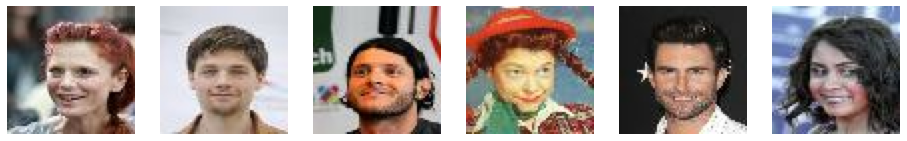

In [4]:
# Display a few examples

n_examples_shown = 6
f, axs = plt.subplots(1, n_examples_shown, figsize=(16, 3))

for j, image in enumerate(train_ds.take(n_examples_shown)):
    axs[j].imshow(image[0])
    axs[j].axis('off')

In [5]:
# Batch the Dataset objects

batch_size = 32
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

In [6]:

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_prior(num_modes, latent_dim):
    """
    This function should create an instance of a MixtureSameFamily distribution 
    according to the above specification. 
    The function takes the num_modes and latent_dim as arguments, which should 
    be used to define the distribution.
    Your function should then return the distribution instance.
    """
    prior = tfd.MixtureSameFamily(mixture_distribution = tfd.Categorical(probs=tf.divide(tf.ones([num_modes,]), num_modes)),
                                 components_distribution = tfd.MultivariateNormalDiag(loc = tf.Variable(tf.random.normal([num_modes, latent_dim]), trainable=True, dtype=tf.float32),
                                                                                      scale_diag = tfp.util.TransformedVariable(initial_value = tf.ones([num_modes, latent_dim]), 
                                                                                                                                bijector = tfb.Softplus()))
                                 )
    
    return prior

In [7]:
# Run your function to get the prior distribution with 2 components and latent_dim = 50

prior = get_prior(num_modes=2, latent_dim=50)

In [8]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_kl_regularizer(prior_distribution):
    """
    This function should create an instance of the KLDivergenceRegularizer 
    according to the above specification. 
    The function takes the prior_distribution, which should be used to define 
    the distribution.
    Your function should then return the KLDivergenceRegularizer instance.
    """
    return tfpl.KLDivergenceRegularizer(distribution_b=prior_distribution,  
                                        use_exact_kl=False, 
                                        weight=1.0, 
                                        test_points_fn=lambda q: q.sample(3),
                                        test_points_reduce_axis = (0,1))
    
    

In [9]:
# Run your function to get the KLDivergenceRegularizer

kl_regularizer = get_kl_regularizer(prior)

In [10]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_encoder(latent_dim, kl_regularizer):
    """
    This function should build a CNN encoder model according to the above specification. 
    The function takes latent_dim and kl_regularizer as arguments, which should be
    used to define the model.
    Your function should return the encoder model.
    """
    model = Sequential([
                        Conv2D(filters=32, kernel_size=(4,4), strides=(2,2), padding="SAME", activation="relu", input_shape=(64, 64, 3)),
                        BatchNormalization(),
                        Conv2D(filters=64, kernel_size=(4,4), strides=(2,2), padding="SAME", activation="relu"),
                        BatchNormalization(),
                        Conv2D(filters=128, kernel_size=(4,4), strides=(2,2), padding="SAME", activation="relu"),
                        BatchNormalization(),
                        Conv2D(filters=256, kernel_size=(4,4), strides=(2,2), padding="SAME", activation="relu"),
                        BatchNormalization(),
                        Flatten(),
                        Dense(units=tfpl.MultivariateNormalTriL.params_size(latent_dim)),
                        tfpl.MultivariateNormalTriL(activity_regularizer=kl_regularizer, event_size=latent_dim)
    ])

    return model


In [11]:
# Run your function to get the encoder

encoder = get_encoder(latent_dim=50, kl_regularizer=kl_regularizer)

In [12]:
encoder.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        1568      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        32832     
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         131200    
                                                                 
 batch_normalization_2 (Batc  (None, 8, 8, 128)        5

In [13]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_decoder(latent_dim):
    """
    This function should build a CNN decoder model according to the above specification. 
    The function takes latent_dim as an argument, which should be used to define the model.
    Your function should return the decoder model.
    """
    model = Sequential([
                        Dense(units=4096, activation="relu", input_shape=(latent_dim,)),
                        Reshape(target_shape=(4, 4, 256)),
                        UpSampling2D(size=(2,2)),
                        Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding="SAME"),
                        UpSampling2D(size=(2,2)),
                        Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="SAME"),
                        UpSampling2D(size=(2,2)),
                        Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding="SAME"),
                        UpSampling2D(size=(2,2)),
                        Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding="SAME"),
                        Conv2D(filters=3, kernel_size=(3,3), padding="SAME"),
                        Flatten(),
                        tfpl.IndependentBernoulli(event_shape=(64, 64, 3))
    ])
    
    return model

In [14]:
# Run your function to get the decoder

decoder = get_decoder(latent_dim=50)

In [15]:
# Print the decoder summary

decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              208896    
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 256)        0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 128)         295040    
                                                                 
 up_sampling2d_1 (UpSampling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)       

In [16]:
# Connect the encoder and decoder

vae = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))

In [17]:

# Complete the following function. 
# Make sure to not change the function name or arguments.

def reconstruction_loss(batch_of_images, decoding_dist):
    """
    This function should compute and return the average expected reconstruction loss,
    as defined above.
    The function takes batch_of_images (Tensor containing a batch of input images to
    the encoder) and decoding_dist (output distribution of decoder after passing the 
    image batch through the encoder and decoder) as arguments.
    The function should return the scalar average expected reconstruction loss.
    """
    return - tf.reduce_mean(decoding_dist.log_prob(batch_of_images))
 

In [18]:
# Compile the model

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer, loss=reconstruction_loss)

### uncomment to train

In [19]:
# vae.fit(train_ds, validation_data=val_ds, epochs=160)


### uncomment to save a checkpoint

In [20]:
# vae.save_weights('vae_160_epochs')


### uncomment to load a checkpoint

In [22]:
vae.load_weights("VaeModel160Epochs weights checkpoint")

In [23]:
# Evaluate the model on the test set

test_loss = vae.evaluate(test_ds)
print("Test loss: {}".format(test_loss))

32/32 [==============================] - 7s 174ms/step - loss: 6254.2051
Test loss: 6254.205078125


In [24]:
 #### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def generate_images(prior, decoder, n_samples):
    """
    This function should compute generate new samples of images from the generative model,
    according to the above instructions.
    The function takes the prior distribution, decoder and number of samples as inputs, which
    should be used to generate the images.
    The function should then return the batch of generated images.
    """
    embeddings = prior.sample(n_samples)
    return decoder(embeddings).mean().numpy()

C:\Users\lazar\AppData\Local\Temp/ipykernel_5548/1326603892.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axs = plt.subplots(1, n_samples, figsize=(3, 3))


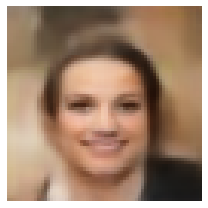

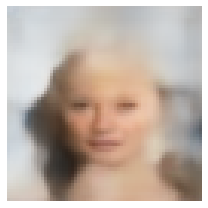

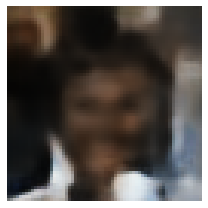

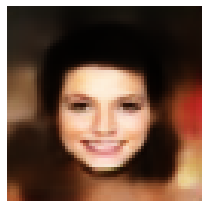

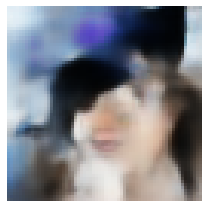

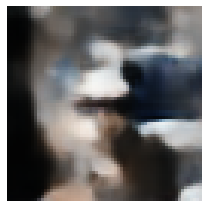

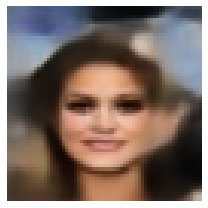

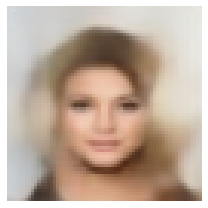

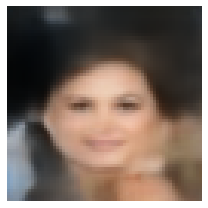

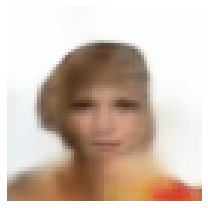

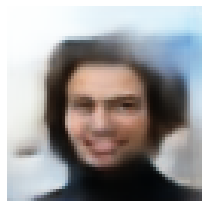

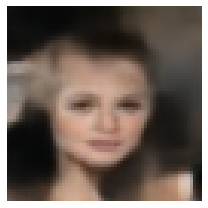

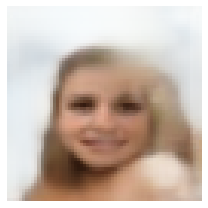

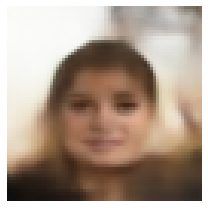

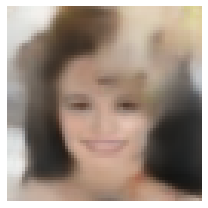

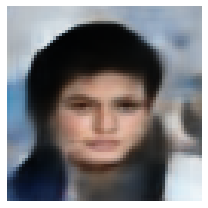

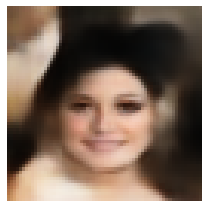

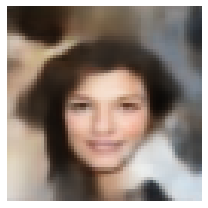

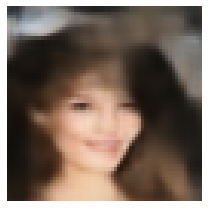

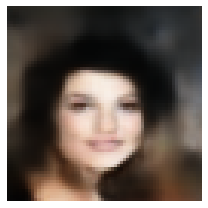

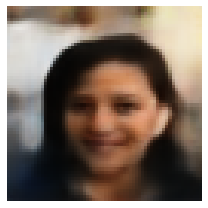

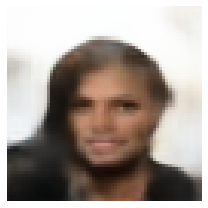

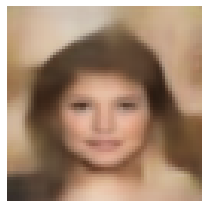

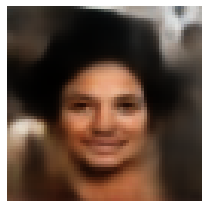

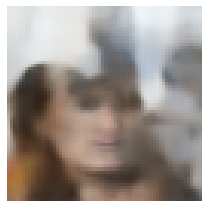

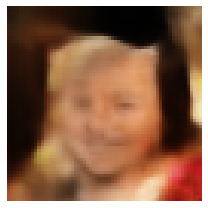

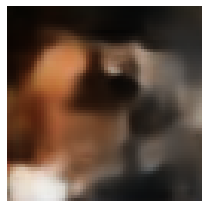

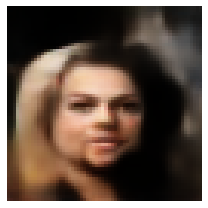

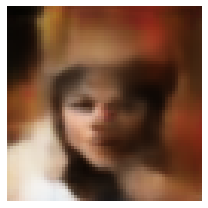

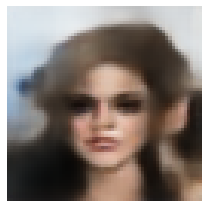

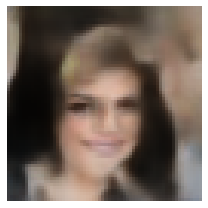

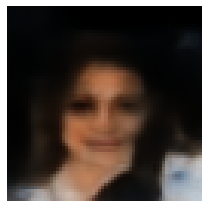

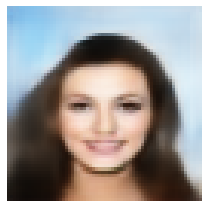

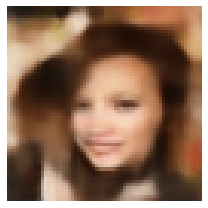

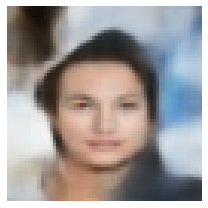

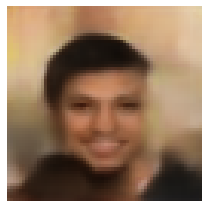

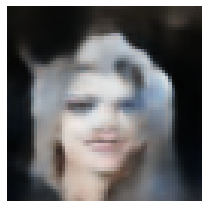

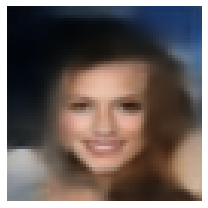

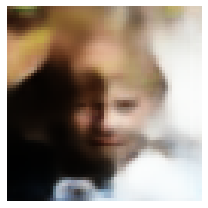

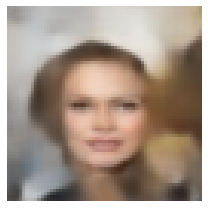

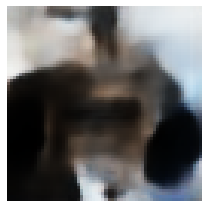

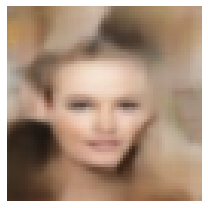

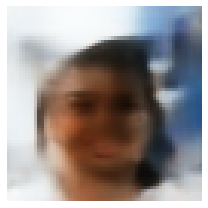

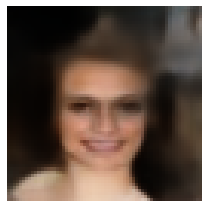

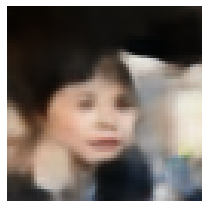

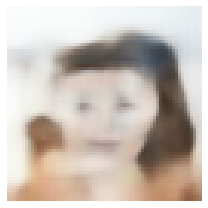

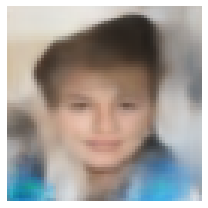

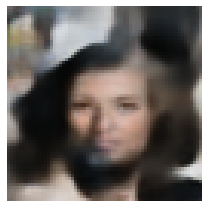

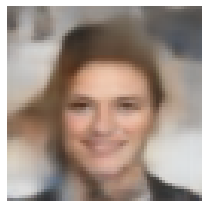

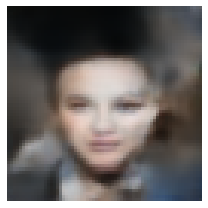

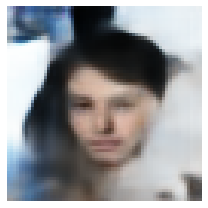

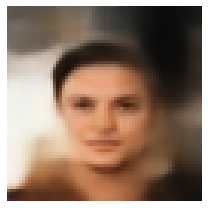

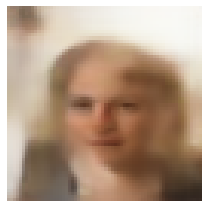

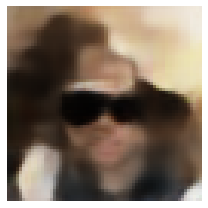

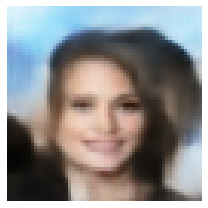

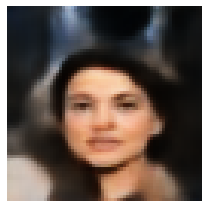

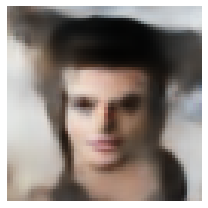

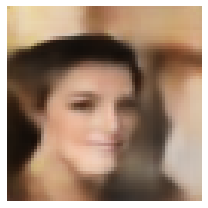

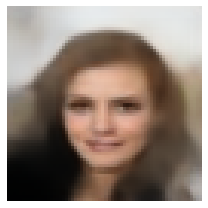

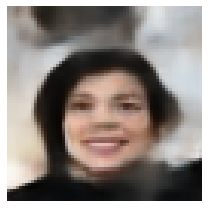

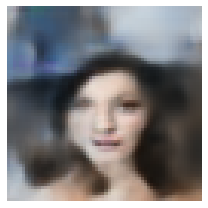

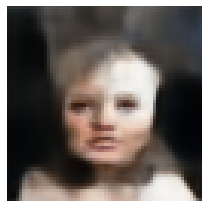

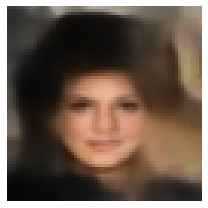

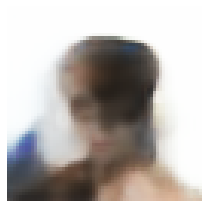

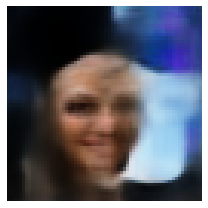

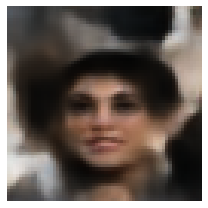

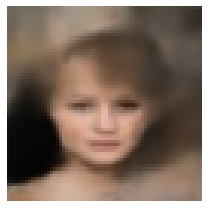

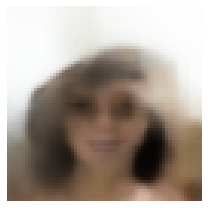

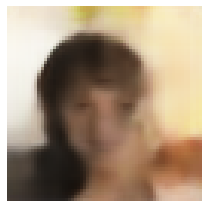

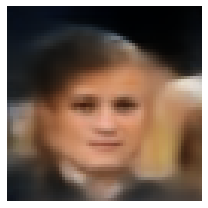

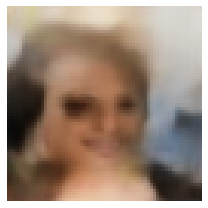

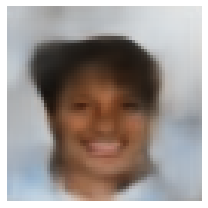

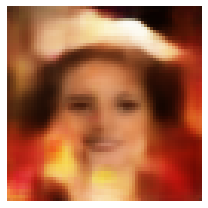

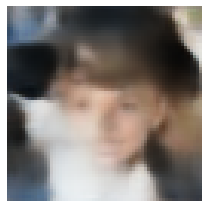

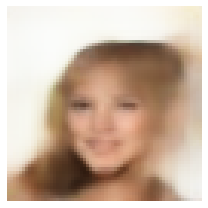

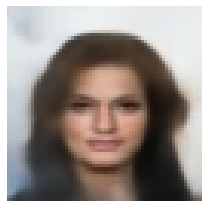

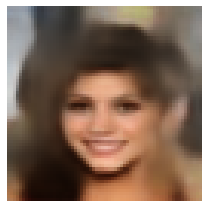

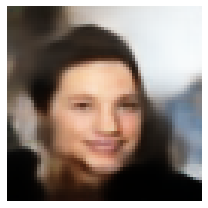

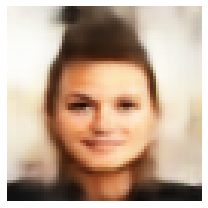

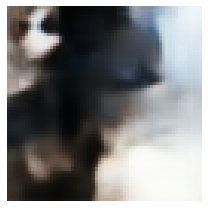

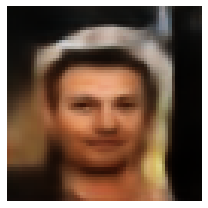

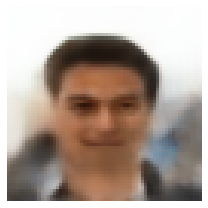

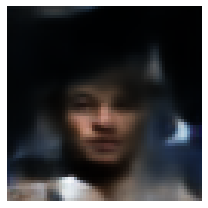

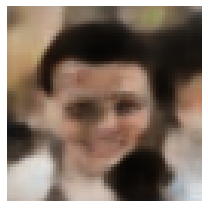

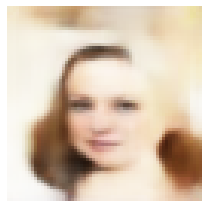

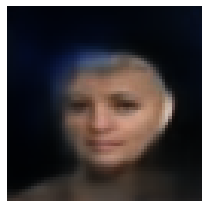

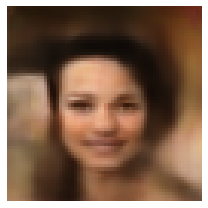

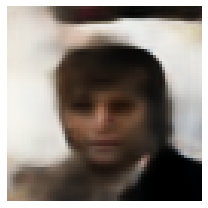

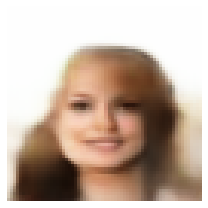

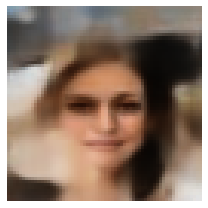

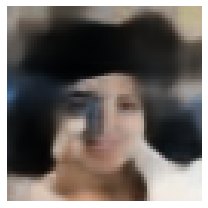

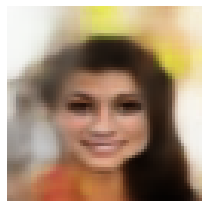

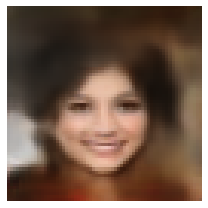

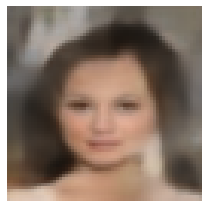

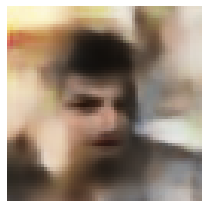

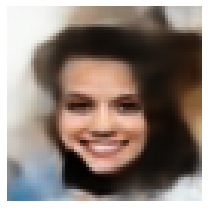

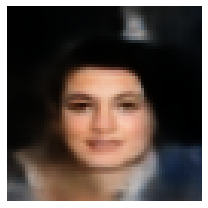

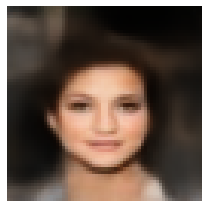

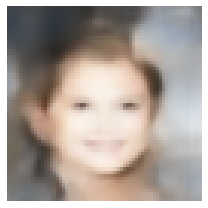

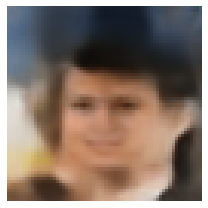

In [26]:
# Run your function to generate new images




pictures = 100
for i in range(pictures):
    n_samples = 1
    sampled_images = generate_images(prior, decoder, n_samples)

    # plt.plot(plt.show())
    # plt.show()


    f, axs = plt.subplots(1, n_samples, figsize=(3, 3))

    for j in range(n_samples):
        axs.imshow(sampled_images[j])
        axs.axis('off')
    
    plt.tight_layout();
    plt.savefig(f'vae_{i+100}.png')
